In [1]:
import numpy as np 
import torch 
from scipy import stats 
from torch import nn 
from d2l import torch as d2l

In [2]:
class HPOTrainer(d2l.Trainer):
    def validation_error(self):
        self.model.eval() 
        accuracy = 0
        val_batch_idx = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x) 
                accuracy += self.model.accuracy(y_hat, y)
            val_batch_idx += 1
        return 1-accuracy/val_batch_idx

In [3]:
def hpo_objective_softmax_classification(config, max_epoch=8):
    learning_rate = config["learning_rate"]
    trainer = d2l.HPOTrainer(max_epochs=max_epoch)
    data = d2l.FashionMNIST(batch_size=16)
    model= d2l.SoftmaxRegression(num_outputs=10, lr = learning_rate)
    trainer.fit(model=model, data=data)
    return trainer.validation_error().detach().numpy()

In [4]:
config_space = {"learning_rate": stats.loguniform(1e-4, 1)}

 validation_error = 0.17019999027252197


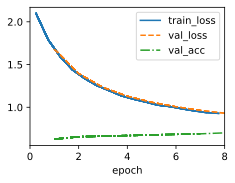

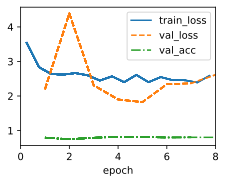

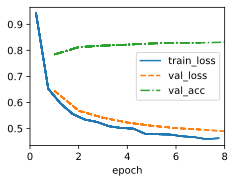

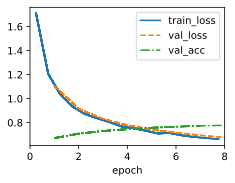

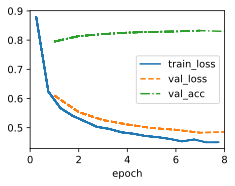

In [5]:
errors , values = [], []
num_iterations = 5

for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f"Trial {i}: learning_rate = {learning_rate}")
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f" validation_error = {y}")
    values.append(learning_rate)
    errors.append(y)

In [6]:
best_idx = np.argmin(errors) 
print(f"optimal learning rate = {values[best_idx]}")

optimal learning rate = 0.005668122965989969


In [7]:
import time 
from scipy import stats 
from d2l import torch as d2l

In [8]:
class HPOSearcher(d2l.HyperParameters):
    def sample_configuration()->dict:
        raise NotImplementedError
    def update(self, config: dict, error: float, additional_info=None):
        pass
    
class RandomSearcher(HPOSearcher):
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()
        
    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else: 
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result

In [9]:
class HPOScheduler(d2l.HyperParameters):
    def suggest(self)->dict:
        raise NotImplementedError
    
    def update(self, config: dict, error: float, info=None):
        raise NotImplementedError
    
class BasicScheduler(HPOScheduler):
    def __init__(self, searcher: HPOSearcher):
        self.save_hyperparameters()
        
    def suggest(self)->dict:
        return self.searcher.sample_configuration()
    
    def update(self, config: dict, error: float, info = None):
        self.searcher.update(config, error, additional_info=info)

In [10]:
class HPOTuner(d2l.HyperParameters):
    def __init__(self, scheduler: HPOScheduler, objective: callable):
        self.save_hyperparameters()
        #Bookeeping results for plotting
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []
    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()
            config = self.scheduler.suggest()
            print(f"Trial {i}: config = {config}")
            error = self.objective(**config) 
            error = float(error.cpu().detach().numpy()) 
            self.scheduler.update(config, error) 
            runtime = time.time() - start_time 
            self.bookkeeping(config, error, runtime)
            print(f" error = {error}, runtime = {runtime}")
            

In [11]:
class HPOSearcher(d2l.HyperParameters):
    def sample_configuration()->dict:
        raise NotImplementedError
    def update(self, config: dict, error: float, additional_info=None):
        pass
    
class RandomSearcher(HPOSearcher):
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()
        
    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else: 
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result

In [12]:
@d2l.add_to_class(HPOTuner)
def bookkeeping(self, config: dict, error: float, runtime: float):
    self.records.append({"config": config, "error": error, "runtime": runtime})
    # check if the last hyperparameter configuration performs better than incumbent
    if self.incumbent is None or self.incumbent_error > error:
        self.incumbent = config
        self.incumbent_error = error
    # add current best observed performance to the optimzaiton trajectory
    self.incumbent_trajectory.append(self.incumbent_error)
    self.current_runtime += runtime
    self.cumulative_runtime.append(self.current_runtime)

In [13]:
def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):
    model = d2l.LeNet(lr = learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=10)
    data = d2l.FashionMNIST(batch_size = batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model=model, data=data)
    validation_error = trainer.validation_error()
    return validation_error

In [14]:
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1), 
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128, }

 error = 0.23842716217041016, runtime = 68.45913171768188


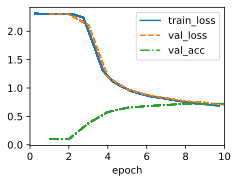

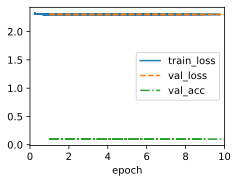

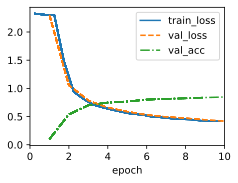

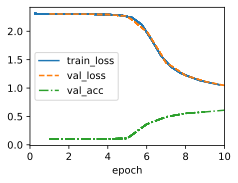

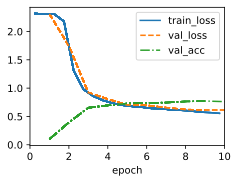

In [ ]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = BasicScheduler(searcher=searcher)
tuner = HPOTuner(scheduler=scheduler, objective=hpo_objective_lenet)
tuner.run(number_of_trials=5)

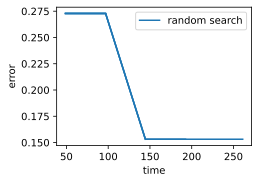

In [ ]:
board = d2l.ProgressBoard(xlabel="time", ylabel="error")
for time_stamp, error in zip( 
                             tuner.cumulative_runtime, tuner.incumbent_trajectory):
    board.draw(time_stamp, error, "random search", every_n=1)

In [16]:
import logging 
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO) 
from syne_tune import StoppingCriterion, Tuner 
from syne_tune.backend.python_backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint 
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch

INFO:root:SMAC is not imported (not contained in extra) since dependencies are missing. You can install them with
   pip install 'syne-tune[smac]'
or (for almost everything)
   pip install 'syne-tune[basic]'


Multi Objective Optimization dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[moo]'
or (for almost everything)
   pip install 'syne-tune[basic]'
Multi Objective Optimization dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[moo]'
or (for almost everything)
   pip install 'syne-tune[basic]'


In [17]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter 
    from d2l import torch as d2l
    
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size) 
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn) 
    report = Reporter() 
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # Initialize the state of Trainer 
            trainer.fit(model=model, data=data) 
        else:
            trainer.fit_epoch() 
        validation_error = trainer.validation_error().cpu().detach().numpy() 
        report(epoch=epoch, validation_error=float(validation_error))

In [18]:
n_workers = 2 # Needs to be <= the number of available GPUs
max_wallclock_time = 12 * 60 # 12 minutes

In [19]:
mode = "min"
metric = "validation_error"

In [20]:
config_space = { "learning_rate": loguniform(1e-2, 1), "batch_size": randint(32, 256), "max_epochs": 10, } 
initial_config = { "learning_rate": 0.1, "batch_size": 128, }

In [21]:
trial_backend = PythonBackend( 
                    tune_function=hpo_objective_lenet_synetune, 
                    config_space=config_space, )

In [22]:
scheduler = RandomSearch( 
                         config_space, 
                         metric=metric, 
                         mode=mode, 
                         points_to_evaluate=[initial_config], )

INFO:syne_tune.optimizer.schedulers.scheduler_searcher:Master random_seed = 1978958612
INFO:syne_tune.optimizer.schedulers.scheduler_searcher:max_resource_level = 10, as inferred from config_space


In [23]:
stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)

tuner = Tuner( 
              trial_backend=trial_backend, 
              scheduler=scheduler, 
              stop_criterion=stop_criterion, 
              n_workers=n_workers, 
              print_update_interval=int(max_wallclock_time * 0.6), )

In [24]:
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /home/shkim/syne-tune/python-entrypoint-2024-07-12-12-08-57-149
INFO:syne_tune.backend.local_backend:Detected 8 GPUs
INFO:syne_tune.backend.local_backend:*** Assigned GPU 0 to trial_id 0
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/shkim/anaconda3/envs/d2l/bin/python /home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root /home/shkim/syne-tune/python-entrypoint-2024-07-12-12-08-57-149/tune_function --tune_function_hash 70d18a4e39d1e4744770f2ddb0ced13c --st_checkpoint_dir /home/shkim/syne-tune/python-entrypoint-2024-07-12-12-08-57-149/0/checkpoints
INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:*** Assigned GPU 1 to trial_id 1
INFO:syne_tune.backend.local_backend:running sub

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0  Completed    10       0.100000         128          10     10          0.267405    56.137898
        1  Completed    10       0.045441         250          10     10          0.682000    52.314846
        2  Completed    10       0.293332         132          10     10          0.199765    53.854819
        3  Completed    10       0.122837         251          10     10          0.399599    51.170003
        4  Completed    10       0.016957          34          10     10          0.340678   103.104157
        5  Completed    10       0.260739         212          10     10          0.244126    50.281612
        6  Completed    10       0.010152         152          10     10          0.899947    51.412198
        7  Completed    10       0.109039          47          10     10          0.263893    73.180346

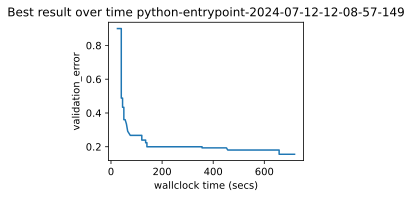

In [25]:
d2l.set_figsize() 
tuning_experiment = load_experiment(tuner.name) 
tuning_experiment.plot()

Text(0, 0.5, 'objective function')

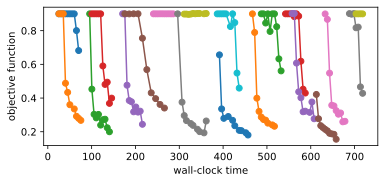

In [26]:
d2l.set_figsize([6, 2.5]) 
results = tuning_experiment.results
for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id] 
    d2l.plt.plot(
        df["st_tuner_time"],
        df["validation_error"],
        marker="o" )
d2l.plt.xlabel("wall-clock time") 
d2l.plt.ylabel("objective function")

In [27]:
from collections import defaultdict 
import numpy as np 
from scipy import stats 
from d2l import torch as d2l

d2l.set_figsize()

In [28]:
class SuccessiveHalvingScheduler(d2l.HPOScheduler): #@save
    def __init__(self, searcher, eta, r_min, r_max, prefact=1):
        self.save_hyperparameters() 
        # Compute K, which is later used to determine the number of␣ ,→ configurations 
        self.K = int(np.log(r_max / r_min) / np.log(eta)) 
        # Define the rungs 
        self.rung_levels = [r_min * eta ** k for k in range(self.K + 1)] 
        if r_max not in self.rung_levels:
            # The final rung should be r_max 
            self.rung_levels.append(r_max) 
            self.K += 1 
        # Bookkeeping 
        self.observed_error_at_rungs = defaultdict(list) 
        self.all_observed_error_at_rungs = defaultdict(list) 
        # Our processing queue 
        self.queue = []

In [29]:
@d2l.add_to_class(SuccessiveHalvingScheduler) #@save
def suggest(self):
    if len(self.queue) == 0:
    # Start a new round of successive halving 
    # # Number of configurations for the first rung: 
        n0 = int(self.prefact * self.eta ** self.K) 
        for _ in range(n0):
            config = self.searcher.sample_configuration()
            config["max_epochs"] = self.r_min # Set r = r_min
            self.queue.append(config) 
    # Return an element from the queue 
    return self.queue.pop()

In [35]:
@d2l.add_to_class(SuccessiveHalvingScheduler) #@save 
def update(self, config: dict, error: float, info=None):
    ri = int(config["max_epochs"]) # Rung r_i
    # Update our searcher, e.g if we use Bayesian optimization later 
    self.searcher.update(config, error, additional_info=info) 
    self.all_observed_error_at_rungs[ri].append((config, error)) 
    if ri < self.r_max:
        # Bookkeeping 
        self.observed_error_at_rungs[ri].append((config, error)) 
        # Determine how many configurations should be evaluated on this rung 
        ki = self.K - self.rung_levels.index(ri) 
        ni = int(self.prefact * self.eta ** ki) 
        if len(self.observed_error_at_rungs[ri]) >= ni:
            kiplus1 = ki - 1
            niplus1 = int(self.prefact * self.eta ** kiplus1)
            best_performing_configurations = self.get_top_n_configurations(
                rung_level=ri, n=niplus1) 
            riplus1 = self.rung_levels[self.K - kiplus1] # r_{i+1} 
            # Queue may not be empty: insert new entries at the beginning 
            self.queue = [
                dict(config, max_epochs=riplus1)
                for config in best_performing_configurations 
                ]  + self.queue
            self.observed_error_at_rungs[ri] = [] # Reset

In [36]:
@d2l.add_to_class(SuccessiveHalvingScheduler) #@save 
def get_top_n_configurations(self, rung_level, n):
    rung = self.observed_error_at_rungs[rung_level]
    if not rung:
        return [] 
    sorted_rung = sorted(rung, key=lambda x: x[1]) 
    return [x[0] for x in sorted_rung[:n]]

In [37]:
min_number_of_epochs = 2 
max_number_of_epochs = 10
eta = 2
num_gpus=1

config_space = { "learning_rate": stats.loguniform(1e-2, 1), "batch_size": stats.randint(32, 256), } 
initial_config = {"learning_rate": 0.1,"batch_size": 128,}

    error = 0.13917529582977295, runtime = 48.49973654747009


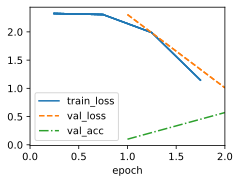

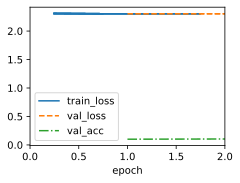

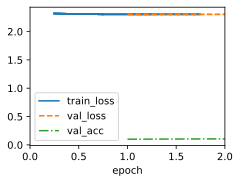

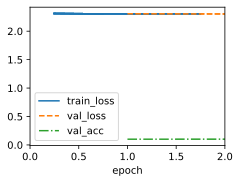

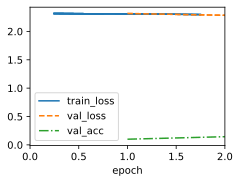

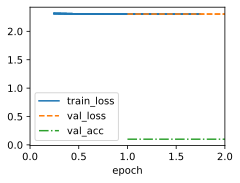

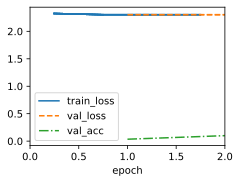

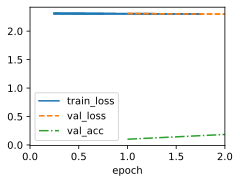

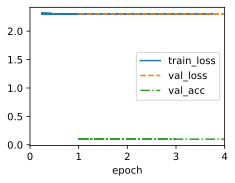

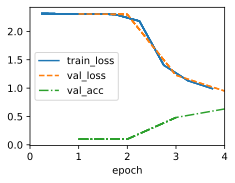

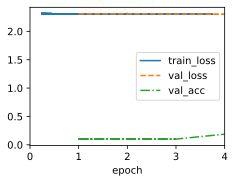

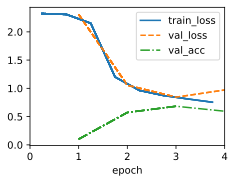

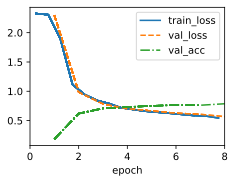

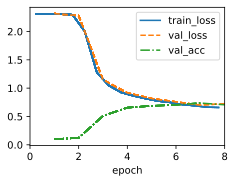

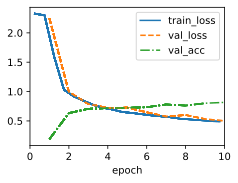

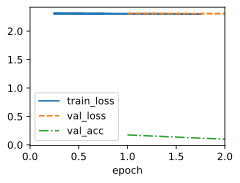

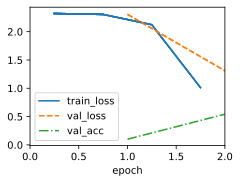

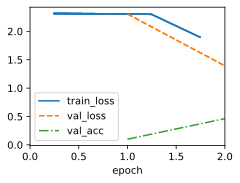

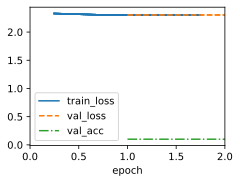

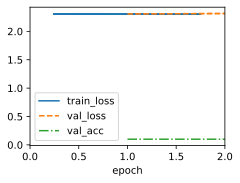

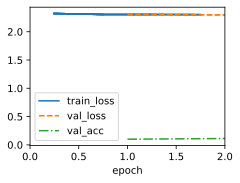

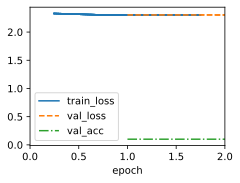

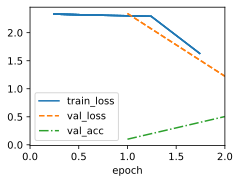

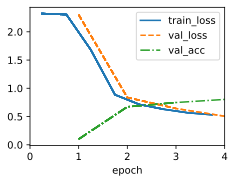

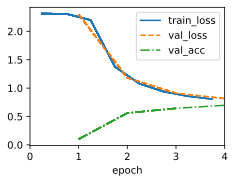

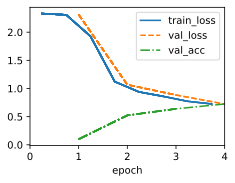

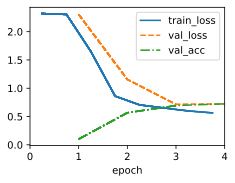

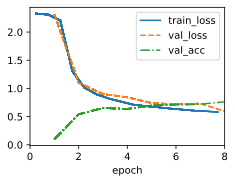

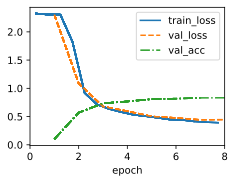

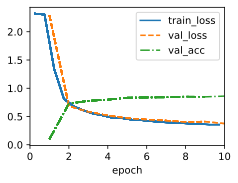

In [38]:
searcher = d2l.RandomSearcher(config_space, initial_config=initial_config) 
scheduler = SuccessiveHalvingScheduler(
    searcher=searcher,
    eta=eta,
    r_min=min_number_of_epochs,
    r_max=max_number_of_epochs, ) 

tuner = d2l.HPOTuner(
    scheduler=scheduler,
    objective=d2l.hpo_objective_lenet, ) 
tuner.run(number_of_trials=30)

Text(0.5, 0, 'epochs')

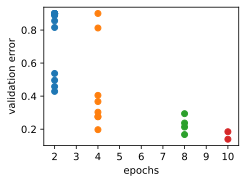

In [39]:
for rung_index, rung in scheduler.all_observed_error_at_rungs.items():
    errors = [xi[1] for xi in rung] 
    d2l.plt.scatter([rung_index] * len(errors), errors) 
d2l.plt.xlim(min_number_of_epochs - 0.5, max_number_of_epochs + 0.5) 
d2l.plt.xticks(np.arange(min_number_of_epochs, max_number_of_epochs + 1),
               np.arange(min_number_of_epochs, max_number_of_epochs + 1)) 
d2l.plt.ylabel("validation error") 
d2l.plt.xlabel("epochs")

In [41]:
import logging 
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO) 
import matplotlib.pyplot as plt 
from syne_tune import StoppingCriterion, Tuner 
from syne_tune.backend.python_backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint 
from syne_tune.experiments import load_experiment 
from syne_tune.optimizer.baselines import ASHA

In [42]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter 
    from d2l import torch as d2l

    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size) 
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn) 
    report = Reporter() 
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # Initialize the state of Trainer 
            trainer.fit(model=model, data=data) 
        else:
            trainer.fit_epoch() 
        validation_error = trainer.validation_error().cpu().detach().numpy() 
        report(epoch=epoch, validation_error=float(validation_error))

In [43]:
min_number_of_epochs = 2 
max_number_of_epochs = 10

eta = 2

config_space = { "learning_rate": loguniform(1e-2, 1), "batch_size": randint(32, 256), "max_epochs": max_number_of_epochs, } 
initial_config = { "learning_rate": 0.1, "batch_size": 128, }

In [44]:
n_workers = 2 # Needs to be <= the number of available GPUs 
max_wallclock_time = 12 * 60 # 12 minutes

In [45]:
mode = "min" 
metric = "validation_error" 
resource_attr = "epoch"

scheduler = ASHA(
    config_space, 
    metric=metric, 
    mode=mode, 
    points_to_evaluate=[initial_config],
    max_resource_attr="max_epochs", 
    resource_attr=resource_attr, 
    grace_period=min_number_of_epochs, 
    reduction_factor=eta,
)

INFO:syne_tune.optimizer.schedulers.scheduler_searcher:Master random_seed = 719869133
INFO:syne_tune.optimizer.schedulers.scheduler_searcher:max_resource_level = 10, as inferred from config_space


In [46]:
trial_backend = PythonBackend( 
                        tune_function=hpo_objective_lenet_synetune, 
                        config_space=config_space, )

stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time) 
tuner = Tuner( 
              trial_backend=trial_backend, 
              scheduler=scheduler, 
              stop_criterion=stop_criterion, 
              n_workers=n_workers, 
              print_update_interval=int(max_wallclock_time * 0.6), ) 
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /home/shkim/syne-tune/python-entrypoint-2024-07-12-14-31-00-249
INFO:syne_tune.backend.local_backend:Detected 8 GPUs
INFO:syne_tune.backend.local_backend:*** Assigned GPU 0 to trial_id 0
INFO:syne_tune.backend.local_backend:running subprocess with command: /home/shkim/anaconda3/envs/d2l/bin/python /home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root /home/shkim/syne-tune/python-entrypoint-2024-07-12-14-31-00-249/tune_function --tune_function_hash 5200e1ede9aeb84c8d97b51b8248310c --st_checkpoint_dir /home/shkim/syne-tune/python-entrypoint-2024-07-12-14-31-00-249/0/checkpoints
INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:*** Assigned GPU 1 to trial_id 1
INFO:syne_tune.backend.local_backend:running sub

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0    Stopped    10       0.100000         128          10   10.0          0.262658    53.584466
        1  Completed    10       0.057004         216          10   10.0          0.582656    52.231612
        2    Stopped     2       0.013100         187          10    2.0          0.899662    11.881519
        3    Stopped     2       0.062158         200          10    2.0          0.900000    11.057525
        4    Stopped    10       0.969655         206          10   10.0          0.188209    53.900818
        5    Stopped     2       0.170393         159          10    2.0          0.899978    10.945398
        6    Stopped     2       0.219380         198          10    2.0          0.900291    11.087412
        7  Completed    10       0.436763          44          10   10.0          0.137028    82.038703

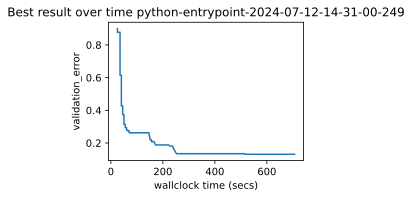

In [47]:
d2l.set_figsize() 
e = load_experiment(tuner.name) 
e.plot()


Text(0, 0.5, 'objective function')

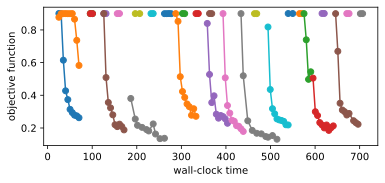

In [48]:
d2l.set_figsize([6, 2.5]) 
results = e.results 
for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id] 
    d2l.plt.plot( 
                 df["st_tuner_time"], 
                 df["validation_error"], 
                 marker="o" ) 
d2l.plt.xlabel("wall-clock time") 
d2l.plt.ylabel("objective function")